# Step 1: convert imternlm model to hf model

In [7]:
!python convert2hf.py --src_folder /path/to/intermlm_model/ --tgt_folder /path/to/save/hf_model/

/home/ma-user/anaconda3/envs/PyTorch-1.8/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)
2024-02-05 18:08:41,399	WARNING utils.py:30 in <module> -- The torch implementation for cal_l2norm is slower than apex. Please note this!


# Step2: Prompted inference

In [19]:
# prepare parameters
prompt_path='./data/seg_prompt/'  # path to prompt
input_img='./data/examples/seg_1.png'  # path to input image
lvm_path='/path/to/lvm_model/'  # path to converted hf model
vqgan_path='/path/to/vqgan_model/'  # path to vqgan model

In [38]:
# import packages
import os

import torch
from PIL import Image
from transformers import AutoModel, GenerationConfig

from model_hf.muse import VQGANModel
from utils import convert_decode_to_pil, encode_transform, patchify, unpatchify
from torchvision import transforms
import matplotlib.pyplot as plt

In [16]:
# prepare models and config
model = AutoModel.from_pretrained(lvm_path, trust_remote_code=True).cuda().eval()
vq_model = VQGANModel.from_pretrained(vqgan_path).cuda().eval()

generation_config = GenerationConfig(
        temperature=0.1,
        top_p=0.75,
        num_beams=1,
        early_stopping=True,
        max_new_tokens=256,
    )

In [28]:
# prepare prompt
img_names = os.listdir(prompt_path)
img_names = sorted(img_names)

seq_prompt, names = [], []
for i, img_name in enumerate(img_names):
    print('prompt: ', img_name)
    img_path = os.path.join(prompt_path, img_name)

    image = Image.open(img_path)
    image = encode_transform(image)
    image = image[0:3,:,:].unsqueeze(0)
    seq_prompt.append(image)

seq_ids = []
for images in seq_prompt:
    images = images.cuda()

    # tokenize
    quantized_states, indices = vq_model.encode(images)
    prompt_ids = indices.reshape(1, -1)
    seq_ids.append(prompt_ids)

seq_ids = torch.cat(seq_ids, dim=1)

print(type(seq_ids), seq_ids.shape)

prompt:  000000_img.png
prompt:  000000_label.png
prompt:  000001_img.png
prompt:  000001_label.png
prompt:  000002_img.png
prompt:  000002_label.png
<class 'torch.Tensor'> torch.Size([1, 1536])


In [43]:
# prepare input
input_img = Image.open(input_img)
img = encode_transform(input_img)[0:3,:,:].unsqueeze(0).cuda()
quantized_states, indices = vq_model.encode(img)
input_ids = indices.reshape(1, -1)
input_ids = torch.cat([seq_ids, input_ids], dim=1)

print(type(input_ids), input_ids.shape)

<class 'torch.Tensor'> torch.Size([1, 1792])


In [34]:
# generate
with torch.no_grad():
    outputs = model.generate(input_ids=input_ids,
                             generation_config=generation_config,
                             max_new_tokens=256,
                             return_dict_in_generate=True,
                             output_scores=True)

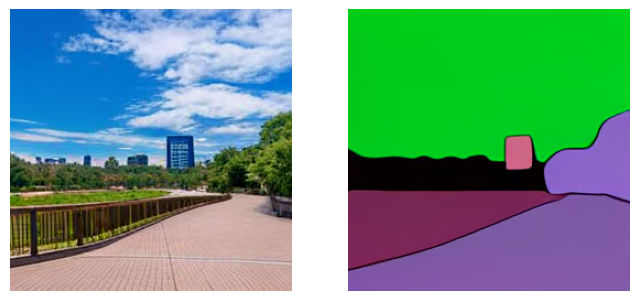

In [47]:
# visulization
generated_tokens = vq_model.quantize.get_codebook_entry_for_lvm(outputs.sequences[:, -256:])
generated_img = vq_model.decode(generated_tokens.view(1, generated_tokens.shape[1] // 16, 16, -1).permute(0, 3, 1, 2))
generated_img_rec = convert_decode_to_pil(generated_img)[0]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(input_img)
axes[1].imshow(generated_img_rec)
for ax in axes:
    ax.axis('off')